# Questioning the Effect of Physiological Heartbeat Synchrony in Romantic Dyads. A Preregistered Deep Learning Analysis.

In [1]:
# For Google Colab / local machine
import tensorflow.keras
ver = tensorflow.version.VERSION

if float(ver[:3]) > 2.7:
  print("Latest TensorFlow version detected -> Prepare Google Colab usage\n")
  google_colab = 1
  from google.colab import drive
  drive.mount('/content/drive/')
  colab_path = "/content/drive/MyDrive/Masterarbeit/Code/two-hearts/"
  import sys
  sys.path.append(colab_path)
else:
  colab_path = ""

In [2]:
# Import libraries
import os
import datetime
import random
import pickle
import IPython
import IPython.display
import numpy as np
from numpy import array, hstack
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot
tensorflow.keras.utils.pydot = pyd

from lists import dyads, num_dyads, participants, num_participants

print("TensorFlow version:",tensorflow.version.VERSION)

TensorFlow version: 2.6.0


## Deep Learning

In [3]:
# Load all results
with open('data_all.pkl', 'rb') as handle: # .pickle # alternative: pd.read_pickle
    data_all = pickle.load(handle)

In [24]:
# Set sampling rate
sampling_rate = 50
print("Sampling rate:", sampling_rate)

# Set number of time steps
n_steps_in, n_steps_out = 5*sampling_rate, 2*sampling_rate
print("Time steps:", n_steps_in, n_steps_out)

# Set conditions
condition = ["sit","gaze","gaze_swap"]
print("Conditions:", condition)

# Show participants 
print("Participants:", participants)

# Show dyads
print("Dyads:", dyads)

# Show number of trials
trial = list(data_all.keys())
print("Number of training trials:",len(trial))

Sampling rate: 50
Time steps: 250 100
Conditions: ['sit', 'gaze', 'gaze_swap']
Participants: ['01', '02', '03', '04']
Dyads: ['01', '02']
Number of training trials: 2


In [19]:
# Load interpolated ECG
# data = np.load("data/data_gaze.npy")

data = np.load(colab_path+"data/data_gaze.npy")

print(data.dtype)
print(data.shape)

float32
(4, 14800)


In [23]:
for x in trial: print(data_all[x]["results_all"])

{'sit': [0.04362959787249565, 0.14726123213768005], 'gaze': [0.030924485996365547, 0.12523052096366882], 'gaze_swap': [0.034299299120903015, 0.13102079927921295]}
{'sit': [0.04553426429629326, 0.15072990953922272], 'gaze': [0.03611404448747635, 0.13419637084007263], 'gaze_swap': [0.03472951799631119, 0.13194513320922852]}


Number of participants: 4
Number of dyads: 2
num_train_samples per dyad: 174
num_vali_samples per dyad: 58
num_test_samples per dyad: 58
Length of samples for each set: 348 116 116


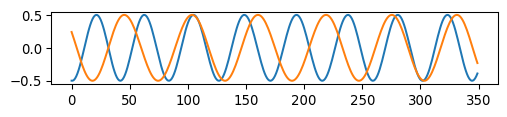

In [22]:
samples = data_all["01"]["samples_all"]["gaze"]

num_participants = len(participants)
num_dyads = len(dyads)

len(samples["X_input_train"])
len(samples["y_output_train"])
len(samples["X_input_train"])

print("Number of participants:", num_participants)
print("Number of dyads:", num_dyads)
print("num_train_samples per dyad:", len(samples["X_input_train"])//num_dyads)
print("num_vali_samples per dyad:", len(samples["X_input_vali"])//num_dyads)
print("num_test_samples per dyad:", len(samples["X_input_test"])//num_dyads)
print("Length of samples for each set:", len(samples["X_input_train"]),len(samples["X_input_vali"]),len(samples["X_input_test"]))

# Plot data
fig = plt.figure(figsize=(6,1), dpi=96)
example = np.append(samples["X_input_train"][14,:,0], samples["y_output_train"][14,:,0])
example2 = np.append(samples["X_input_train"][14,:,1], samples["y_output_train"][14,:,1])
plt.plot(example)
plt.plot(example2)


In [25]:
model = load_model(data_all["01"]["model_all"]["gaze"]) # install nomkl if kernel dies here because of kmp duplicate library

In [27]:
results = model.evaluate(samples["X_input_test"], samples["y_output_test"], batch_size=64)


2/2 [==============================] - 1s 194ms/step - loss: 0.0309 - mae: 0.1252


[0.030924484133720398, 0.12523050606250763]

In [12]:
data_all["01"]["results_all"]["gaze"]

[0.030924485996365547, 0.12523052096366882]

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 250, 2)]     0                                            
__________________________________________________________________________________________________
lstm_20 (LSTM)                  [(None, 100), (None, 41200       input_21[0][0]                   
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 100)          400         lstm_20[0][0]                    
__________________________________________________________________________________________________
repeat_vector_10 (RepeatVector) (None, 100, 100)     0           batch_normalization_20[0][0]     
___________________________________________________________________________________________

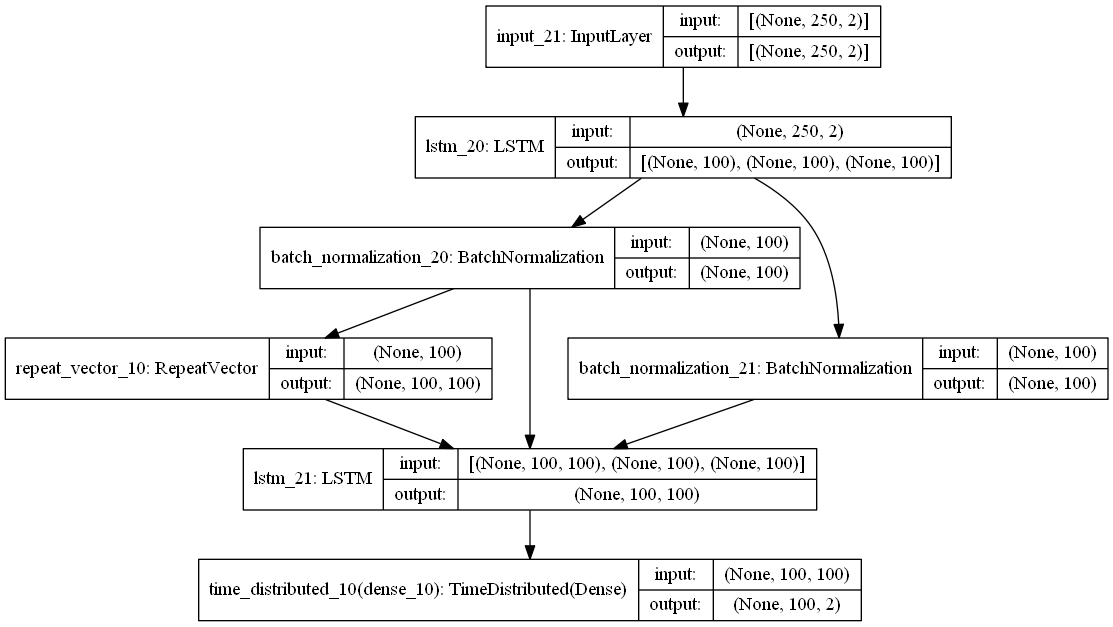

In [10]:
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [8]:
# Define simple seq2seq model 
# Modified from Wieniawska 2020 
# (https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb)

def lstm_decoder_encoder(samples, n_hidden = 100):
    # Input layer
    input_train = Input(shape=(samples["X_input_train"].shape[1], samples["X_input_train"].shape[2]))
    output_train = Input(shape=(samples["y_output_train"].shape[1], samples["y_output_train"].shape[2]))
    # print(input_train)
    # print(output_train)

    # Encoder LSTM with state_h and state_c
    encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_sequences=False, return_state=True)(input_train)
    # print(encoder_last_h1)
    # print(encoder_last_h2)
    # print(encoder_last_c)

    # Batch normalisation to avoid gradient explosion
    encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
    encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

    # Decoder LSTM
    decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
    decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
        decoder, initial_state=[encoder_last_h1, encoder_last_c])
    # print(decoder)

    # Dense layer with repeated weights
    out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
    # print(out)

    # Compile model
    model = Model(inputs=input_train, outputs=out)
    opt = Adam(learning_rate=0.001, clipnorm=1)
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])
    model.summary()
    print(model)

    return model

In [29]:
# Define seq2seq model with Luong attention
# Modified from Wieniawska 2020 
# (https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb)

def lstm_decoder_encoder_luong_attention(samples, n_hidden = 100):
    # Input layer
    input_train = Input(shape=(samples["X_input_train.shape[1]"], samples["X_input_train.shape[2]"]))
    output_train = Input(shape=(samples["y_output_train.shape[1]"], samples["y_output_train.shape[2]"]))

    # Encoder LSTM
    encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
        n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
        return_state=True, return_sequences=True)(input_train)
    # print(encoder_stack_h)
    # print(encoder_last_h)
    # print(encoder_last_c)

    # Batch normalisation to avoid gradient explosion
    encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
    encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

    # Decoder LSTM
    decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
    # print(decoder_input)

    decoder_stack_h = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
    return_state=False, return_sequences=True)(
    decoder_input, initial_state=[encoder_last_h, encoder_last_c])
    # print(decoder_stack_h)

    # Attention layer
    attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
    attention = Activation('softmax')(attention)
    # print(attention)

    # Calculate context vector with batch normalisation
    context = dot([attention, encoder_stack_h], axes=[2,1])
    context = BatchNormalization(momentum=0.6)(context)
    # print(context)

    # Combine context vector with stacked hidden states of decoder for input to the last dense layer
    decoder_combined_context = concatenate([context, decoder_stack_h])
    # print(decoder_combined_context)

    # Dense layer with repeated weights
    out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
    # print(out)

    # Compile model
    model = Model(inputs=input_train, outputs=out)
    opt = Adam(learning_rate=0.001, clipnorm=1)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
    model.summary()
    print(model)

    return model

In [9]:
# Fit model
def fit_model(model, samples):
    epc = 5
    es = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)
    history = model.fit(samples["X_input_train"], samples["y_output_train"],  validation_data=(samples["X_input_vali"],samples["y_output_vali"]), 
                        epochs=epc, verbose=1, callbacks=[es], 
                        batch_size=64, shuffle=False)

    return model, history

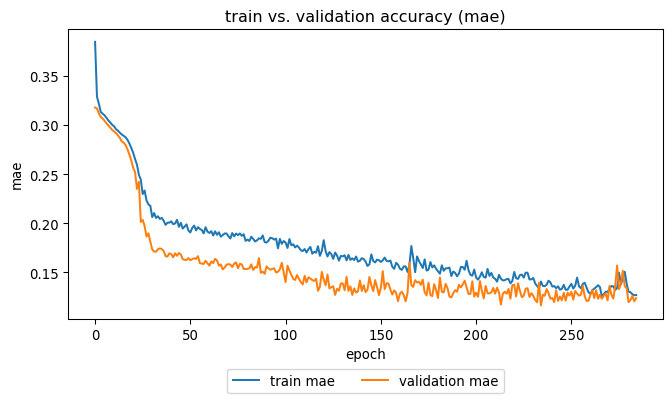

In [31]:
history = data_all["01"]["history_all"]["gaze"]

train_mae = history['mae']
valid_mae = history['val_mae']

fig = plt.figure(figsize=(8,4), dpi=96)
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [32]:
yhat_output_train = model.predict(samples["X_input_train"],batch_size=10)
yhat_output_test = model.predict(samples["X_input_test"],batch_size=10)
print(yhat_output_train.shape, yhat_output_test.shape)
print(samples["y_output_train"].shape, samples["y_output_test"].shape)

(348, 100, 2) (116, 100, 2)
(348, 100, 2) (116, 100, 2)


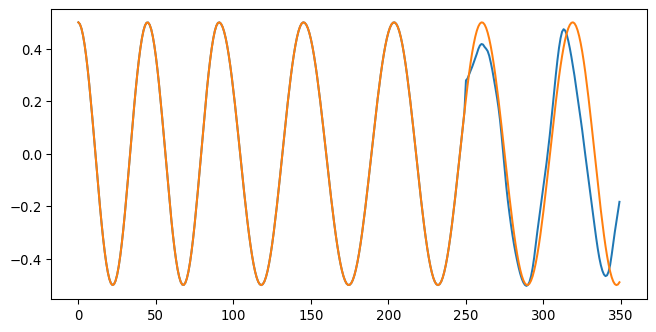

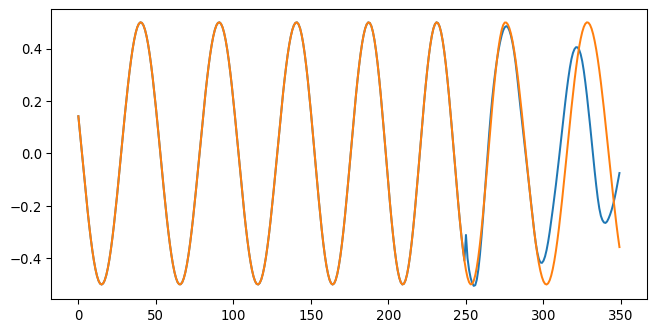

In [33]:
# Graphical demonstration
trial = 12
person = 1

# demonstrate training

train_hat = np.append(samples["X_input_train"][trial,:,person],yhat_output_train[trial,:,person])
train = np.append(samples["X_input_train"][trial,:,person],samples["y_output_train"][trial,:,person])

fig = plt.figure(figsize=(8,4), dpi=96)
plt.figure(1)
plt.plot(train_hat)
plt.plot(train)

# demonstrate prediction

test_hat = np.append(samples["X_input_test"][trial,:,person],yhat_output_test[trial,:,person])
test = np.append(samples["X_input_test"][trial,:,person],samples["y_output_test"][trial,:,person])

fig = plt.figure(figsize=(8,4), dpi=96)
plt.figure(2)

plt.plot(test_hat)
plt.plot(test)

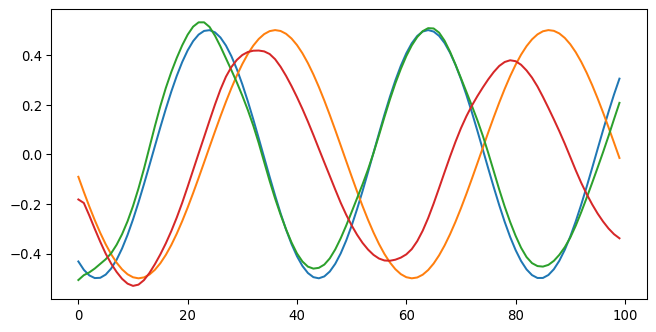

In [34]:
fig = plt.figure(figsize=(8,4), dpi=96)
plt.plot(samples["y_output_test"][1])
plt.plot(yhat_output_test[1])

In [35]:
data_final = {
  "train_pred": yhat_output_train,
  "train_true": samples["y_output_train"],
  "test_pred": yhat_output_test,
  "test_true": samples["y_output_test"]
}

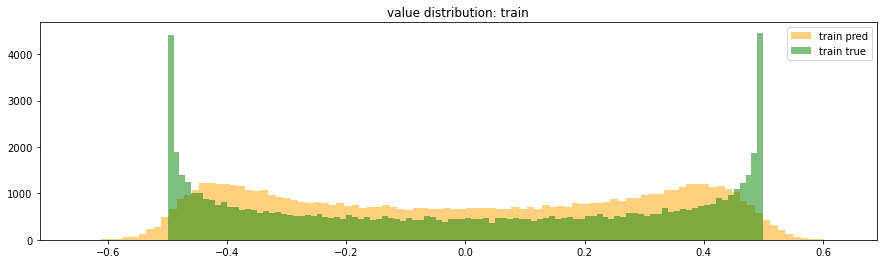

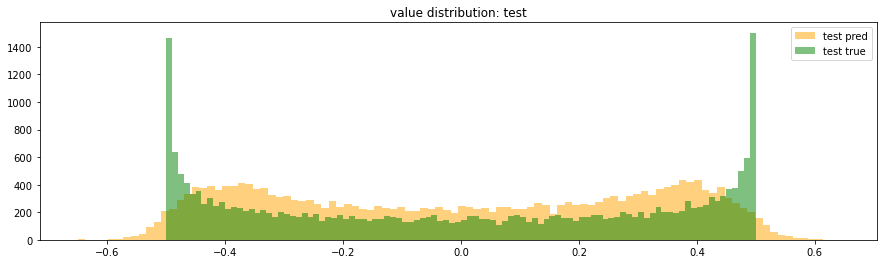

In [36]:
# Plot value distribution
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

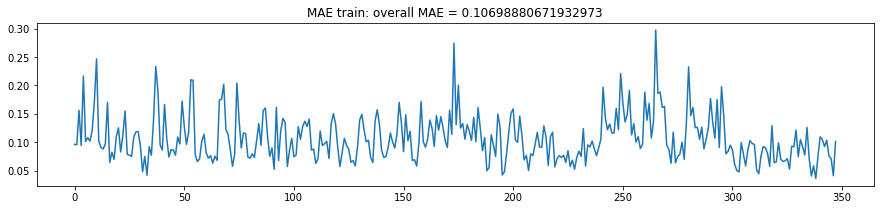

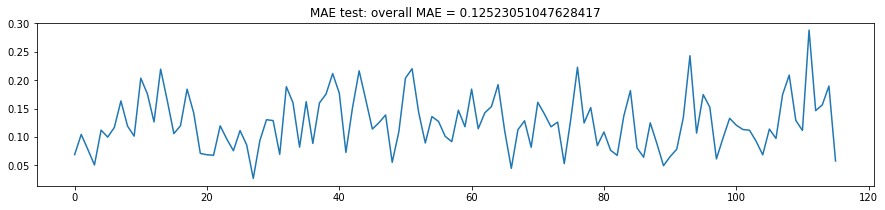

In [37]:
# plot MAE of all samples in time order, to see if there is clear pattern (which means more training is needed)
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()

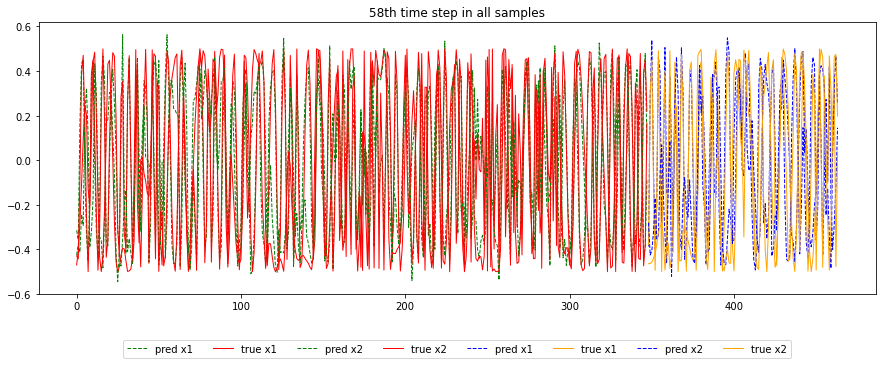

In [38]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

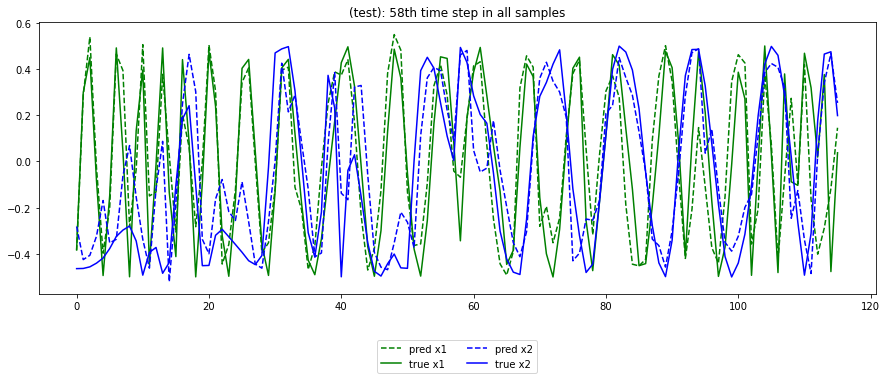

In [39]:
# Check the nth prediction of each time step
lb = 'test'
plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [41]:
# Evaluate the model on the test data using evaluate`
print("Evaluate on test data")
results = model.evaluate(samples["X_input_test"], samples["y_output_test"], batch_size=64)
print("test loss, test acc:", results)

Evaluate on test data
2/2 [==============================] - 0s 182ms/step - loss: 0.0309 - mae: 0.1252
test loss, test acc: [0.030924484133720398, 0.12523050606250763]


Evaluate on test data
2/2 [==============================] - 0s 119ms/step - loss: 0.0380 - mae: 0.1406
test loss, test acc: [0.038016945123672485, 0.14056797325611115]

Evaluate on test data
2/2 [==============================] - 0s 128ms/step - loss: 0.0372 - mae: 0.1409
test loss, test acc: [0.03717455640435219, 0.14091217517852783]